In [1]:
import sys
Path = '/remote/tychodata/ftairli/work/Projects/Recurrent_Geometry_Reconstruction/Code/'
if Path not in sys.path:
    sys.path.append(Path)
    
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from Dataset import LSTMProcessingDatasetContainer, DatasetContainer
from TrainingModule import IterateInBatches

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [2]:
Name = 'Model_2_0_Recipient'
Model = torch.load(f'{Name}.pt')
Tracker = torch.load(f'{Name}_Tracker.pt')
print(Model.Description)


    Part of the Model_2_X series
    The Recipient Model

    Predict Without Aux Data
    Transplant the LSTM Weights from the Donor Model
    


In [3]:
MinValLossEpoch = np.argmin(Tracker.EpochValLoss)
Model.load_state_dict(Tracker.ModelStates[MinValLossEpoch])

<All keys matched successfully>

In [4]:
# Load Dataset
datapath = '/remote/tychodata/ftairli/work/Projects/Recurrent_Geometry_Reconstruction/Data/NormData/'
datapath_Raw = '/remote/tychodata/ftairli/work/Projects/Recurrent_Geometry_Reconstruction/Data/RawData/'
dataset = DatasetContainer(0)
dataset.Load(datapath_Raw, 'Run010')


ProcessingDataset = LSTMProcessingDatasetContainer()
ProcessingDataset.Load(datapath,'Run010')

from Training import GetTruths,GetRecTruths

ProcessingDataset.AssignIndices()
ProcessingDataset.RandomIter = False

In [5]:
def UnnormaliseOutputs(Outputs):
    Chi0 = torch.acos(Outputs[:,0])
    Mean_Rp = 12800
    STD_Rp  = 5800
    Rp      = Outputs[:,1]*STD_Rp + Mean_Rp
    return torch.stack([Chi0, Rp], dim=1)

def MeanSquaredError(Truths,Predictions):
    return ((Truths-Predictions)**2).mean()
def MeanAbsoluteError(Truths,Predictions):
    return (np.abs(Truths-Predictions)).mean()
def Percentile68(Truths,Predictions):
    return np.percentile(np.abs(Truths-Predictions),68)

In [6]:
def ComputePreds(Model,ProcessingDataset):
        
    # Compute the Test Set
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    RecTruths = GetRecTruths(dataset)

    ProcessingDataset.State = 'Test'
    Truth = []
    Pred  = []
    Model.eval()
    EvI = 0
    with torch.no_grad():
        for EventIndex,BatchTraces, BatchAux,BatchTruth in IterateInBatches(ProcessingDataset,256):
            # BatchTraces      = torch.zeros_like(BatchTraces)+123
            BatchTraces      = BatchTraces     .to(device)
            BatchAux         = BatchAux        .to(device)
            BatchTruth       = BatchTruth      .to(device)
            
            Truth.append(BatchTruth)
            Pred.append(Model(BatchTraces, BatchAux))
            EvI+=1

    Truth = torch.cat(Truth, dim=0)
    Pred  = torch.cat(Pred , dim=0)

    Truth = UnnormaliseOutputs(Truth)
    Pred  = UnnormaliseOutputs(Pred)

    Truth = Truth.cpu()
    Pred  = Pred .cpu()


    # drop NaN values
    if True:
        Mask = ~torch.isnan(Truth[:,0]) & ~torch.isnan(Truth[:,1]) & ~torch.isnan(Pred[:,0]) & ~torch.isnan(Pred[:,1]) 
        print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
        Truth = Truth[Mask]
        Pred  = Pred [Mask]


    Truth = Truth.numpy()
    Pred  = Pred .numpy()

    return Truth,Pred

Truth,Pred = ComputePreds(Model,ProcessingDataset)
print(f'68th Percentile Chi0: {Percentile68(Truth[:,0],Pred[:,0])}')
print(f'68th Percentile Rp  : {Percentile68(Truth[:,1],Pred[:,1])}')

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.76 GiB. GPU 0 has a total capacty of 9.77 GiB of which 1.50 GiB is free. Process 12918 has 3.20 GiB memory in use. Process 18224 has 2.54 GiB memory in use. Including non-PyTorch memory, this process has 1.31 GiB memory in use. Of the allocated memory 268.88 MiB is allocated by PyTorch, and 19.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Scramble the Aux variables

In [ ]:
AuxVariables = {'Station_Dist':0,'LastPixel_Station_ChiDiff':1,'LastPixel_Station_TimeDiff':2,'None':None}

In [ ]:
Chi0_PCs = {}
Rp_PCs   = {}
Lengths  = {}

for ScrambleVariable in AuxVariables:
    ProcessingDataset = LSTMProcessingDatasetContainer()
    ProcessingDataset.Load(datapath,'Run010')
    ProcessingDataset.AssignIndices()
    ProcessingDataset.RandomIter = False

    # Randomise the ScrambleVariable
    if ScrambleVariable != 'None':
        ProcessingDataset.AuxInputs[:,AuxVariables[ScrambleVariable]] = ProcessingDataset.AuxInputs[torch.randperm(len(ProcessingDataset.AuxInputs)),AuxVariables[ScrambleVariable]]
    
    Truth,Pred = ComputePreds(Model,ProcessingDataset)
    Chi0_PCs[ScrambleVariable] = Percentile68(Truth[:,0],Pred[:,0])
    Rp_PCs  [ScrambleVariable] = Percentile68(Truth[:,1],Pred[:,1])
    Lengths [ScrambleVariable] = len(Truth)

Dropping 763 NaN values
Dropping 1315 NaN values
Dropping 1836 NaN values
Dropping 0 NaN values


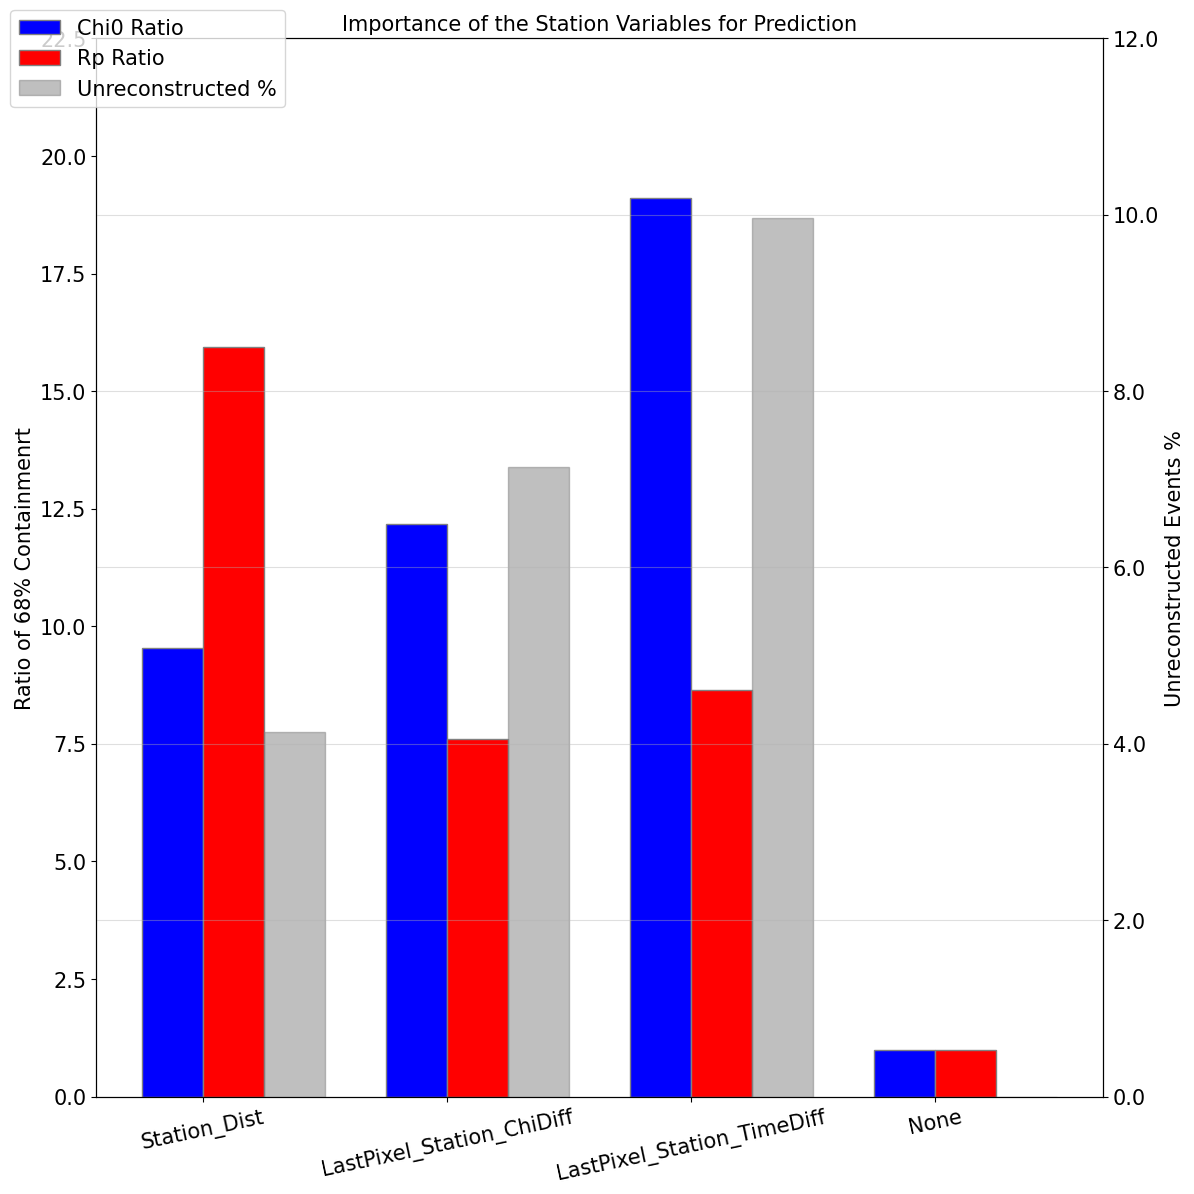

In [ ]:
# Plot the ratio of scramble variables to the None
Chi0_Ratio = []
Rp_Ratio   = []
Len_Ratio  = []
for ScrambleVariable in AuxVariables:
    Chi0_Ratio.append(Chi0_PCs[ScrambleVariable]/Chi0_PCs['None'])
    Rp_Ratio  .append(Rp_PCs  [ScrambleVariable]/Rp_PCs  ['None'])
    Len_Ratio .append(1-Lengths [ScrambleVariable]/Lengths ['None'])

Chi0_Ratio = np.array(Chi0_Ratio)
Rp_Ratio   = np.array(Rp_Ratio)
Len_Ratio  = np.array(Len_Ratio)*100 # Turn to %



# Define variables
variables = list(AuxVariables.keys())

# Create figure and axis
fig, ax = plt.subplots(figsize = [12,12])

# Set width of bars
bar_width = 0.25

# Set position of bar on X axis
r1 = range(len(variables))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot bars
ax.bar(r1, Chi0_Ratio, color='b', width=bar_width, edgecolor='grey', label='Chi0 Ratio')
ax.bar(r2, Rp_Ratio  , color='r', width=bar_width, edgecolor='grey', label='Rp Ratio')
axt = ax.twinx()
axt.bar(r3, Len_Ratio , color='grey', width=bar_width, edgecolor='grey', label='Unreconstructed %',alpha = 0.5)

# ax.set_xlabel('Variables')
ax.set_ylabel('Ratio of 68% Containmenrt',fontsize = 15)
axt.set_ylabel('Unreconstructed Events %',fontsize = 15)

ax.set_xticks(ticks = [r + bar_width/2 for r in range(len(variables))],labels = variables,rotation=12,fontsize = 15)
ax.set_yticks(ticks = ax.get_yticks(),labels = ax.get_yticks(),fontsize = 15)
axt.set_yticks(ticks = axt.get_yticks(),labels = axt.get_yticks(),fontsize = 15)

ax.set_title('Importance of the Station Variables for Prediction',fontsize = 15)

# Create legend & Show graphic
fig.tight_layout()
fig.legend(loc='upper left',fontsize = 15)
plt.grid(alpha = 0.4)
plt.show()

# Now Zero Out the Traces

In [ ]:
TraceVariables = {'Signal':0,'Chi_i':1,'Time_TG':2,'None':None}

Chi0_PCs = {}
Rp_PCs   = {}
Lengths  = {}

for ScrambleVariable in TraceVariables:
    ProcessingDataset = LSTMProcessingDatasetContainer()
    ProcessingDataset.Load(datapath,'Run010')
    ProcessingDataset.AssignIndices()
    ProcessingDataset.RandomIter = False

    # Randomise the ScrambleVariable
    if ScrambleVariable != 'None':
        ProcessingDataset.TraceInputs[:,:,TraceVariables[ScrambleVariable]] = 0
    
    Truth,Pred = ComputePreds(Model,ProcessingDataset)
    Chi0_PCs[ScrambleVariable] = Percentile68(Truth[:,0],Pred[:,0])
    Rp_PCs  [ScrambleVariable] = Percentile68(Truth[:,1],Pred[:,1])
    Lengths [ScrambleVariable] = len(Truth)

Dropping 0 NaN values
Dropping 17 NaN values
Dropping 34 NaN values
Dropping 0 NaN values


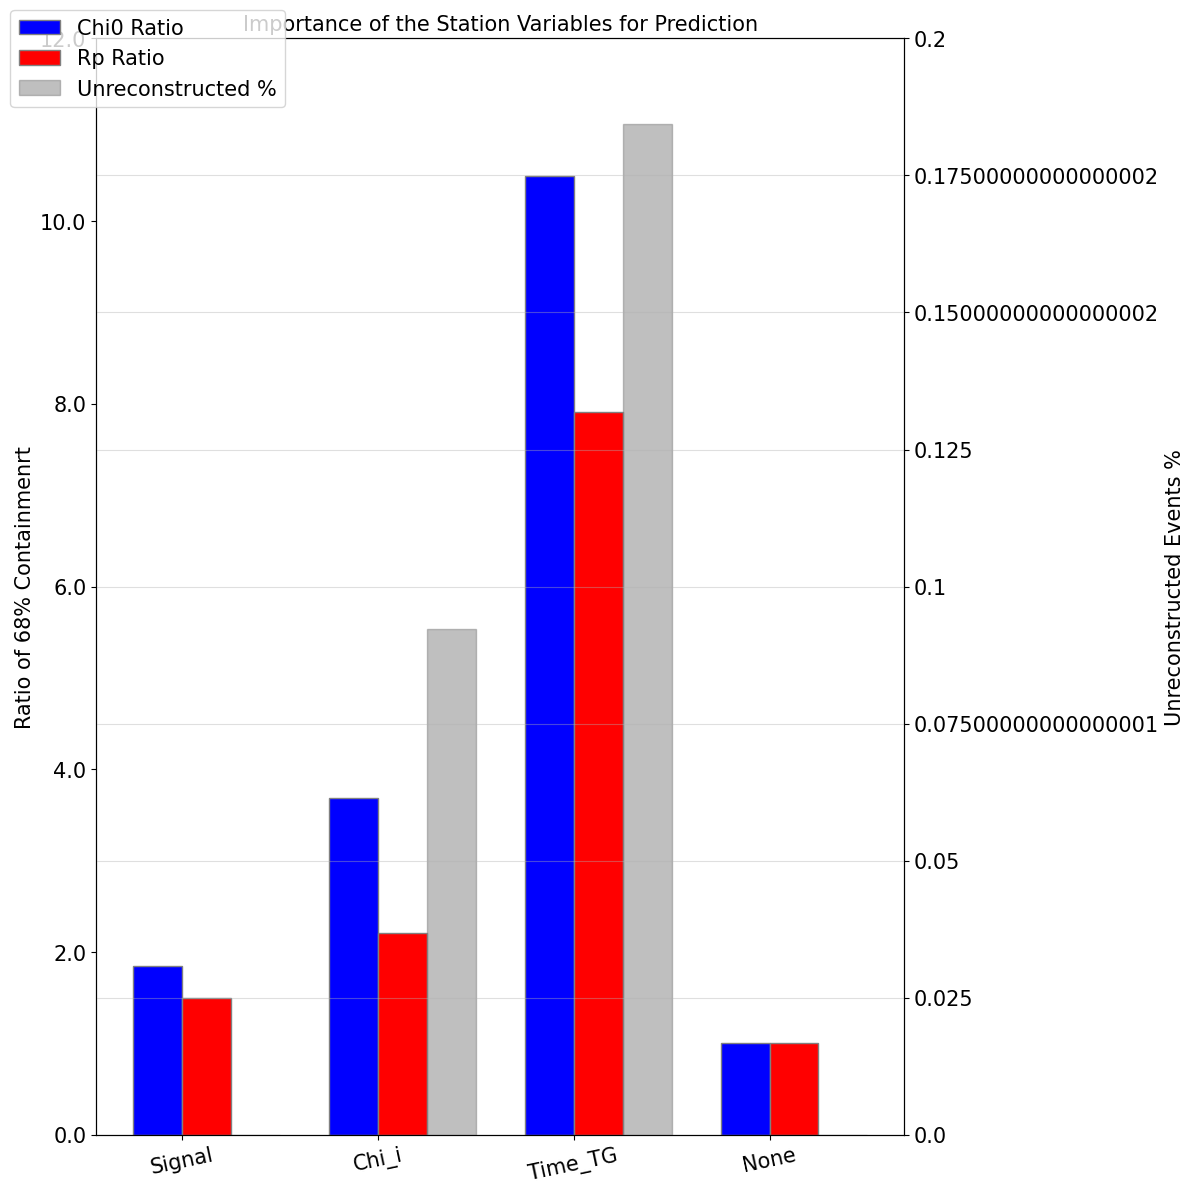

In [ ]:
# Plot the ratio of scramble variables to the None
Chi0_Ratio = []
Rp_Ratio   = []
Len_Ratio  = []
for ScrambleVariable in TraceVariables:
    Chi0_Ratio.append(Chi0_PCs[ScrambleVariable]/Chi0_PCs['None'])
    Rp_Ratio  .append(Rp_PCs  [ScrambleVariable]/Rp_PCs  ['None'])
    Len_Ratio .append(1-Lengths [ScrambleVariable]/Lengths ['None'])

Chi0_Ratio = np.array(Chi0_Ratio)
Rp_Ratio   = np.array(Rp_Ratio)
Len_Ratio  = np.array(Len_Ratio)*100 # Turn to %



# Define variables
variables = list(TraceVariables.keys())

# Create figure and axis
fig, ax = plt.subplots(figsize = [12,12])

# Set width of bars
bar_width = 0.25

# Set position of bar on X axis
r1 = range(len(variables))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot bars
ax.bar(r1, Chi0_Ratio, color='b', width=bar_width, edgecolor='grey', label='Chi0 Ratio')
ax.bar(r2, Rp_Ratio  , color='r', width=bar_width, edgecolor='grey', label='Rp Ratio')
axt = ax.twinx()
axt.bar(r3, Len_Ratio , color='grey', width=bar_width, edgecolor='grey', label='Unreconstructed %',alpha = 0.5)

# ax.set_xlabel('Variables')
ax.set_ylabel('Ratio of 68% Containmenrt',fontsize = 15)
axt.set_ylabel('Unreconstructed Events %',fontsize = 15)

ax.set_xticks(ticks = [r + bar_width/2 for r in range(len(variables))],labels = variables,rotation=12,fontsize = 15)
ax.set_yticks(ticks = ax.get_yticks(),labels = ax.get_yticks(),fontsize = 15)
axt.set_yticks(ticks = axt.get_yticks(),labels = axt.get_yticks(),fontsize = 15)

ax.set_title('Importance of the Station Variables for Prediction',fontsize = 15)

# Create legend & Show graphic
fig.tight_layout()
fig.legend(loc='upper left',fontsize = 15)
plt.grid(alpha = 0.4)
plt.show()